# Kaggle Study 11일차(home_credit)

코드출처 : https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering

## Introduction: Manual Feature Engineering
이 대회에 처음 참가하시는 분들은 이 노트북을 확인해 보시기를 강력히 권합니다.

이 노트북에서는 홈 크레딧 디폴트 리스크 경연대회를 위해 직접 기능을 만드는 방법에 대해 알아보겠습니다. 이전 노트북에서는 모델을 구축하기 위해 애플리케이션 데이터만 사용했습니다. 이 데이터로 만든 최고의 모델은 약 0.74의 리더보드에서 점수를 얻었습니다. 이 점수를 더 잘 받으려면 다른 데이터 프레임의 정보를 더 많이 포함해야 합니다. 여기서, 우리는 bureau 및 bureau_balance 데이터의 활용을 살펴볼 것이다. 이러한 데이터 파일의 정의는 다음과 같습니다.

- Bureau: 고객이 이전에 다른 금융 기관과의 대출에 대한 정보를 홈 크레딧에 보고했습니다. 이전 대출에는 각각 자체 행이 있습니다.
- bure_balance: 이전 대출에 대한 월별 정보입니다. 각 달에는 자체 행이 있습니다.

수동 기능 엔지니어링은 지루한 프로세스일 수 있으며(그래서 기능 툴과 함께 자동화된 기능 엔지니어링을 사용하는 이유!) 종종 도메인 전문지식에 의존합니다. 저는 대출에 대한 도메인 지식이 제한되어 있고, 어떤 점이 사람을 디폴트할 가능성이 높기 때문에, 대신 가능한 한 많은 정보를 최종 교육 데이터 프레임으로 얻는 데 집중할 것입니다. 모델은 우리가 그것을 결정해야 하는 것보다 어떤 특징들이 중요한지 알게 될 것이다. 기본적으로, 우리의 접근 방식은 가능한 많은 기능을 만든 다음 사용할 모델에 모든 기능을 제공하는 것입니다! 나중에 모델의 기능 중요도 또는 PCA와 같은 다른 기술을 사용하여 기능 축소를 수행할 수 있다.

수동 형상 공학의 과정은 많은 판다 코드, 약간의 인내심, 그리고 많은 훌륭한 연습 조작 데이터를 필요로 할 것이다. 자동화된 기능 엔지니어링 도구를 사용할 수 있게 되기는 하지만, 기능 엔지니어링은 여전히 몇 시간 동안 많은 데이터 논쟁을 사용하여 수행되어야 합니다.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

## Example: Counts of a client's previous loans
수동 기능 엔지니어링의 일반적인 프로세스를 설명하기 위해 먼저 다른 금융 기관에서 고객의 이전 대출 수를 간단히 파악할 수 있습니다. 이를 위해서는 노트북 전반에 걸쳐 많은 팬더 작업을 수행해야 합니다.

- groupby : 데이터 프레임을 열별로 그룹화합니다. 이 경우 고유한 클라이언트인 SK_를 기준으로 그룹화합니다.ID_CURR 열입니다.
- agg: 열의 평균을 구하는 것과 같이 그룹화된 데이터에 대해 계산을 수행합니다. 함수를 직접 호출하거나(grouped_df.mean() 변환 목록과 함께 agg 함수를 사용할 수 있습니다([grouped_df.agg([평균, 최대, 최소, 합계])
- merge: 집계된 통계를 적절한 클라이언트와 일치시킵니다. 원래 교육 데이터를 SK_의 계산된 통계와 병합해야 합니다.ID_CURR 열 - 클라이언트가 해당 통계를 가지고 있지 않은 셀에 NaN을 삽입합니다.  
  
또한 사전으로 이름을 바꿀 열을 지정하는 (이름 변경) 기능도 상당히 많이 사용합니다. 이 기능은 우리가 생성하는 새 변수를 추적하는 데 유용합니다.

이것은 많은 것처럼 보일 수 있습니다. 그래서 우리는 결국 우리를 위해 이 과정을 할 수 있는 기능을 쓸 것입니다. 먼저 이것을 수작업으로 실행하는 것을 살펴보겠습니다.

In [2]:
bureau = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/home_credit/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [5]:
# 클라이언트 ID로 그룹화합니다(SK_ID_CURR), 이전 대출 수를 세고 열의 이름을 변경합니다.
previous_loan_counts = bureau.groupby('SK_ID_CURR',as_index=False)['SK_ID_BUREAU'].count().rename(columns={'SK_ID_BUREAU':'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [6]:
#train값이랑 결합
train = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/home_credit/application_train.csv')
train = train.merge(previous_loan_counts,on='SK_ID_CURR',how='left')

#결측치 0으로 매꾸기
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


오른쪽 끝까지 스크롤하면 새 열이 표시됩니다.

### Assessing Usefulness of New Variable with r value
새 변수가 유용한지 여부를 확인하기 위해 이 변수와 대상 사이의 Pearson 상관 계수(r-값)를 계산할 수 있습니다. 이 값은 두 변수 사이의 선형 관계의 강도를 측정하고 -1(완전 음수 선형)에서 +1(완전 양수 선형)까지의 범위를 측정합니다. r-값은 새 변수의 "유용도"에 대한 최선의 척도는 아니지만 변수가 기계 학습 모델에 도움이 될지 여부에 대한 첫 번째 근사치를 제공할 수 있습니다. 목표값에 대한 변수의 r-값이 클수록 이 변수의 변화는 목표값에 더 많은 영향을 미칠 수 있습니다. 따라서 목표값에 상대적인 절대값 r-값이 가장 큰 변수를 찾습니다.

또한 KDE(Kernel Density Assessment) 그림을 사용하여 대상과의 관계를 시각적으로 검사할 수도 있습니다.

#### Kernel Density Estimate Plots
커널 밀도 추정치 그림에는 단일 변수의 분포가 표시됩니다(평활 히스토그램이라고 생각함). 범주형 변수의 값에 따라 분포의 차이를 확인하려면 범주에 따라 분포의 색을 다르게 지정할 수 있습니다. 예를 들어, TARGET = 1인지 0인지 여부에 따라 색상이 지정된 이전_count의 커널 밀도 추정치를 표시할 수 있습니다. 결과 KDE는 대출금을 상환하지 않은 사람(Target == 1)과 상환하지 않은 사람(Target == 0) 사이의 변수 분포에서 유의한 차이를 보입니다. 이는 변수가 기계 학습 모델과 '관련'되는지 여부를 나타내는 지표가 될 수 있습니다.

우리는 이 플로팅 기능을 모든 변수에 다시 사용할 수 있는 함수에 넣을 것입니다.

In [17]:
def kde_target(var_name,df):
    
    #상관관게 계산
    corr = df['TARGET'].corr(df[var_name])
    
    #Target == 0/Target == 1인값 각각 중간값 계산
    avg_repaid = df.loc[df['TARGET']==0,var_name].median()
    avg_not_repaid = df.loc[df['TARGET']==1,var_name].median()
    
    plt.figure(figsize=(12,6))
    
    sns.kdeplot(df.loc[df['TARGET']==0,var_name],label='TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET']==1,var_name],label='TARGET == 1')
    
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title('%s Distribution'% var_name)
    plt.legend()
    
    print('The correlation between %s and the TARGET is %0.4f'%(var_name,corr))
    print('Median value for loan that was not repaid id = %0.4f'% avg_not_repaid)
    print('Median value for loan that was repaid id = %0.4f'% avg_repaid)
    

랜덤 포리스트 및 그라데이션 부스팅 머신에 따라 가장 중요한 변수 중 하나로 밝혀진 EXT_SOURCE_3 변수를 사용하여 이 함수를 테스트할 수 있습니다.

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid id = 0.3791
Median value for loan that was repaid id = 0.5460


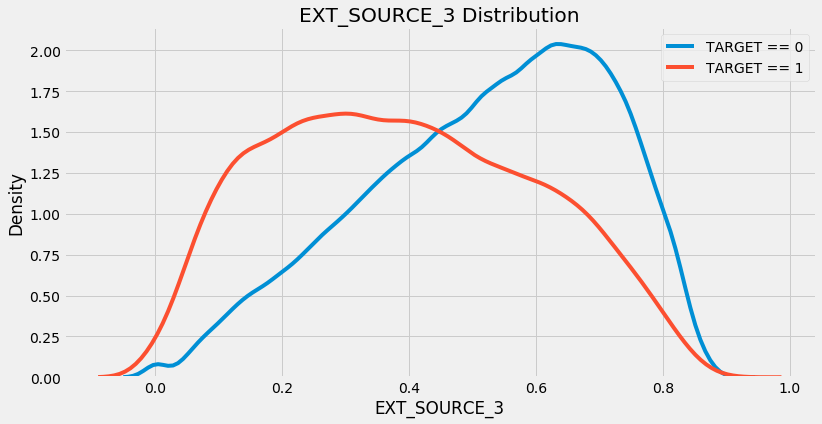

In [18]:
kde_target('EXT_SOURCE_3',train)

새로 만든 변수(previous_loan_counts)도 한번 테스트 해보자

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid id = 3.0000
Median value for loan that was repaid id = 4.0000


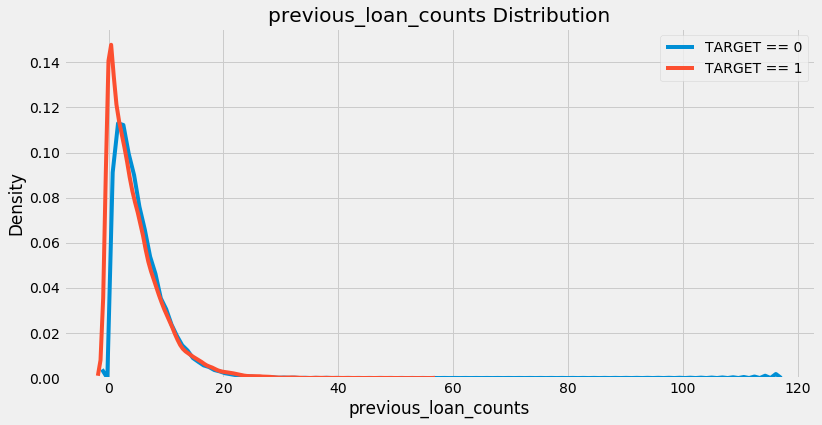

In [19]:
kde_target('previous_loan_counts',train)

이 변수로는 이 변수가 중요한지 여부를 알 수 없습니다. 상관 계수가 매우 약하고 분포에서 거의 눈에 띄는 차이가 없습니다.

이제 bureau 데이터 프레임에서 몇 가지 변수를 더 만들어 보겠습니다. bureau 데이터 프레임에 있는 모든 숫자 열의 평균, 최소 및 최대값을 가져옵니다.

### Aggregating Numeric Columns
bureau 데이터 프레임의 숫자 정보를 설명하기 위해 모든 숫자 열에 대한 통계를 계산할 수 있습니다. 이를 위해 클라이언트 ID별로 그룹화하고, 그룹화된 데이터 프레임을 집계한 다음, 결과를 교육 데이터에 다시 병합합니다. agg 함수는 연산이 유효한 것으로 간주되는 숫자 열의 값만 계산합니다. 우리는 '평균', 'max', 'min', 'sum'을 계속 사용할 것이지만, 어떤 기능이라도 여기에 전달될 수 있습니다. 우리는 심지어 우리 자신의 기능을 써서 agg함수를 사용할 수도 있습니다.

In [20]:
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

각 열에 대한 새 이름을 만들어야 합니다. 다음 코드는 이름에 stat을 추가하여 새 이름을 만듭니다. 여기서는 데이터 프레임에 다중 레벨 인덱스가 있다는 사실을 다루어야 합니다. 저는 이것들이 혼란스럽고 함께 일하기 어렵다는 것을 알고 있기 때문에 가능한 한 빨리 단일 레벨 인덱스로 줄이려고 노력합니다.

In [24]:
columns = ['SK_ID_CURR']

for var in bureau_agg.columns.levels[0]:

    if var != 'SK_ID_CURR':
        for stat in bureau_agg.columns.levels[1][:-1]:
            columns.append('bureau_%s_%s' % (var, stat))

In [25]:
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


이제 이전처럼 교육 데이터와 병합할 수 있습니다.

In [26]:
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


#### Correlations of Aggregated Values with Target
모든 새 값의 상관 관계를 목표값과 계산할 수 있습니다. 다시 말해, 이러한 변수를 모형화에 중요한 변수의 근사치로 사용할 수 있습니다.

In [27]:
new_corrs = []

for col in columns:

    corr = train['TARGET'].corr(train[col])
    
    new_corrs.append((col, corr))

아래 코드에서는 sort 함수를 사용하여 상관 관계를 크기(절대값)별로 정렬합니다. 우리는 또한 알기 좋은 또 다른 중요한 파이썬 작업인 lambda 함수를 사용합니다.

In [28]:
new_corrs = sorted(new_corrs,key=lambda x:abs(x[1]),reverse=True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.08972896721998122),
 ('bureau_DAYS_CREDIT_min', 0.0752482510301036),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968668),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.05588737984392113),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.05373489560102051),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758661),
 ('bureau_DAYS_CREDIT_max', 0.049782054639973095),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.04885350261111589),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275433483543),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.042863922470730176),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484684),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.04140363535306004),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.036589634696329046),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.03428110992161599),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.030492306653325547)]

어떤 변수도 목표값과 유의한 상관 관계를 갖지 않습니다. 상관 관계가 가장 높은 변수인 bureau_DAYS_CREDIT_mean이 가장 높은 관계를 볼 수 있습니다. 

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid id = -835.3333
Median value for loan that was repaid id = -1067.0000


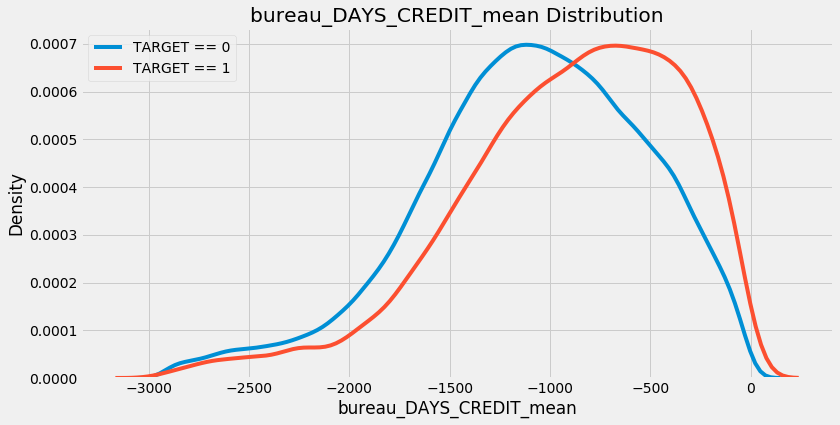

In [29]:
kde_target('bureau_DAYS_CREDIT_mean',train)

이 열의 정의는 "현재 신청된 고객이 신용장 크레딧을 신청하기 전 일"입니다. 제가 해석하는 바는 이전 대출이 홈크레딧에 대출 신청하기 전에 신청한 일수입니다. 따라서 마이너스 수치가 크면 대출이 현재 대출 신청보다 더 이전임을 나타냅니다. 우리는 이 변수의 평균과 목표값 사이에 극히 약한 긍정적인 관계가 있다고 봅니다. 이는 과거에 대출을 더 신청했던 고객들이 잠재적으로 홈 크레딧에서 대출을 상환할 가능성이 더 높다는 것을 의미합니다. 하지만 이렇게 약한 상관 관계에서는 신호와 마찬가지로 노이즈일 가능성이 높습니다.

#### The Multiple Comparisons Problem
변수가 많을 때 일부 변수는 단순한 우연에 의해 상관 관계가 있을 것으로 예상합니다. 다중 비교로 알려진 문제입니다. 우리는 수백 가지의 기능을 만들 수 있고, 일부는 단순히 데이터의 무작위 노이즈 때문에 목표값과 상관관계가 있는 것으로 밝혀질 것입니다. 그런 다음, 모델이 훈련할 때 이러한 변수가 훈련 세트의 목표값과 관계가 있다고 생각하기 때문에 이러한 변수에 지나치게 적합할 수 있지만, 이것이 반드시 테스트 세트에 일반화될 필요는 없습니다. 특징을 만들 때 고려해야 할 많은 것들이 있습니다!

### Function for Numeric Aggregations
이전의 모든 작업을 함수로 캡슐화해 보겠습니다. 이를 통해 모든 데이터 프레임에서 숫자 열에 대한 집계 통계를 계산할 수 있습니다. 다른 데이터 프레임에도 동일한 작업을 적용하고자 할 때 이 기능을 다시 사용할 것입니다.

In [30]:
def agg_numeric(df, group_var, df_name):
    """
    데이터 프레임의 숫자 값을 집계합니다.
    그룹화 변수의 각 인스턴스에 대한 피쳐를 작성하는 데 사용할 수 있습니다.
    
    매개 변수
    --------
        df(데이터 프레임): 
            통계를 계산할 데이터 프레임입니다.
        group_var(string): 
            df를 그룹화할 변수입니다.
        df_name(string): 
            열 이름을 바꾸는 데 사용되는 변수입니다.
        
    리턴 값
    --------
        agg(데이터 프레임): 
            통계가 집계된 데이터 프레임입니다. 
            모든 숫자 열을 선택합니다. 그룹화 변수의 각 인스턴스에는 다음이 포함됩니다. 
            계산된 통계량(평균, 최소, 최대값, 합, 현재 지원됨)입니다. 
            또한 생성된 기능을 추적하기 위해 열 이름이 변경됩니다.
    """
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
    
    columns = [group_var]

    for var in agg.columns.levels[0]:
        if var != group_var:
            for stat in agg.columns.levels[1][:-1]:
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [31]:
bureau_agg_new = agg_numeric(bureau.drop(columns=['SK_ID_BUREAU']),group_var='SK_ID_CURR',df_name='bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


기능이 의도한 대로 작동되도록 하기 위해, 우리는 손으로 만든 집계된 데이터 프레임과 비교해야 합니다.

In [32]:
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


만약 우리가 그 값들을 조사한다면, 우리는 그것들이 동등하다는 것을 알게 됩니다. 우리는 이 기능을 다른 데이터 프레임에 대한 숫자 통계를 계산하는 데 재사용할 수 있을 것입니다. 기능을 사용하면 일관된 결과를 얻을 수 있고 앞으로 우리가 해야 할 일의 양을 줄일 수 있습니다!

#### Correlation Function
다음으로 넘어가기 전에 대상과의 상관 관계를 계산하는 코드를 함수로 만들 수도 있습니다.

In [33]:
def target_corr(df):
    corrs = []
    
    for col in df.columns:
        print(col)
        if col != 'TARGET':
            corr = df['TARGET'].corr(df[col])
            corrs.append((col,corr))
            
    corrs = sorted(corrs,key=lambda x : abs(x[1]),reverse=True)
    
    return corrs

### Categorical Variables
이제 숫자 열에서 범주형 열로 이동합니다. 이 변수들은 이산형 문자열 변수이므로 숫자 변수에서만 작동하는 평균 및 최대값과 같은 통계량만 계산할 수 없습니다. 대신, 각 범주형 변수 내에서 각 범주의 값 개수를 계산하는 데 의존합니다. 예를 들어 다음과 같은 데이터 프레임을 사용할 수 있습니다.

우리는 이 정보를 각 고객에 대한 각 범주의 대출 수를 세어 사용할 것입니다.

그런 다음 해당 관측치에 대한 범주형 변수의 총 발생 횟수(각 관측치에 대해 정규화된 카운트의 합이 1.0이어야 함을 의미)로 이러한 값 카운트를 정규화할 수 있습니다.

이러한 방식으로 범주형 변수를 인코딩하면 해당 변수가 포함된 정보를 캡처할 수 있습니다. 이 과정에 대해 더 좋은 아이디어가 있는 사람이 있다면 댓글로 알려주세요! 이제 이 프로세스를 단계별로 살펴보겠습니다. 마지막으로, 우리는 모든 코드를 하나의 기능으로 마무리하여 많은 데이터 프레임에 다시 사용할 것입니다.

먼저 범주형 열(dtype == 'object')만 사용하여 데이터 프레임을 one-hot 인코딩합니다.

In [35]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


In [37]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum','mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

sum 열은 관련 클라이언트에 대한 해당 범주의 개수를 나타내고 mean은 정규화된 카운트를 나타냅니다. 단일 핫 인코딩을 사용하면 이러한 수치를 쉽게 계산할 수 있습니다!

이전과 유사한 기능을 사용하여 열의 이름을 바꿀 수 있습니다. 다시 한 번, 우리는 열에 대한 다단계 지수를 다루어야 합니다. 우리는 (원핫 인코딩에서) 범주 값에 추가된 범주형 변수의 이름인 첫 번째 수준(레벨 0)까지 반복합니다. 그런 다음 각 클라이언트에 대해 계산된 통계를 반복합니다. 통계가 추가된 레벨 0 이름으로 열의 이름을 변경합니다. 예를 들어 CREDIT_ACTIVE_Active를 레벨 0으로 하고 합계를 레벨 1로 하는 열은 CREDIT_ACTIVE_Active_count가 됩니다.

In [38]:
categorical_grouped.columns.levels[0][:10]

Index(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan'],
      dtype='object')

In [39]:
categorical_grouped.columns.levels[1]

Index(['sum', 'mean'], dtype='object')

In [40]:
group_var = 'SK_ID_CURR'

columns = []

for var in categorical_grouped.columns.levels[0]:
    if var != group_var:
        for stat in ['count','count_norm']:
            columns.append('%s_%s'%(var,stat))
            
categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


합계 열은 카운트를 기록하고 평균 열은 정규화된 카운트를 기록합니다.

이 데이터 프레임을 교육 데이터에 병합할 수 있습니다.

In [41]:
train = train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index =True,how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
train.shape

(307511, 229)

In [43]:
train.iloc[:10,123:]

,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,8.0,-874.000000,-103.0,-1437.0,-6992.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,-1400.750000,-606.0,-2586.0,-5603.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,-867.000000,-408.0,-1326.0,-1734.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,-1149.000000,-1149.0,-1149.0,-1149.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,-757.333333,-78.0,-1097.0,-2272.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,18.0,-1271.500000,-239.0,-2882.0,-22887.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.0,-1939.500000,-1138.0,-2741.0,-3879.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,-1773.000000,-1309.0,-2508.0,-7092.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Function to Handle Categorical Variables
코드를 보다 효율적으로 만들기 위해 이제 범주형 변수를 처리하는 함수를 작성할 수 있습니다. 데이터 프레임과 그룹화 변수를 수용한다는 점에서 agg_numeric 함수와 동일한 형식을 취합니다. 그런 다음 데이터 프레임의 모든 범주형 변수에 대한 각 범주의 카운트 및 정규화된 카운트를 계산합니다.

In [52]:
def count_categorical(df,group_var,df_name):

    categorical = pd.get_dummies(df.select_dtypes('object'))
    categorical[group_var] = df[group_var]
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []

    for var in categorical.columns.levels[0]:
        for stat in ['count','count_norm']:
            column_names.append('%s_%s_%s'%(df_name,var,stat))
            
    categorical.columns = column_names

    return categorical

In [53]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


#### Applying Operations to another dataframe
이제 Bureau balance data frame으로 전환하겠습니다. 이 데이터 프레임에는 각 고객의 다른 금융 기관과의 이전 대출에 대한 월별 정보가 있습니다. 이 데이터 프레임을 SK_로 그룹화하지 않습니다.클라이언트 ID인 ID_CURR은 먼저 SK_로 데이터 프레임을 그룹화할 것입니다.  
ID_BREAU는 이전 대출의 ID입니다. 이렇게 하면 각 대출에 대해 데이터 프레임의 행이 하나씩 제공됩니다. 그런 다음 SK_로 그룹화할 수 있습니다.ID_CURR과 각 클라이언트의 대출에 대한 집계를 계산합니다. 최종 결과는 각 클라이언트에 대해 하나의 행이 있는 데이터 프레임으로, 대출에 대한 통계가 계산됩니다.

In [54]:
bureau_balance = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/home_credit/bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


먼저 각 대출의 상태별 가치 카운트를 계산할 수 있습니다. 다행스럽게도, 우리는 이미 우리를 위해 이것을 하는 기능을 가지고 있습니다!

In [55]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


이제 숫자 열 하나를 처리할 수 있습니다. MONILS_BALANCE 열에 "적용일 대비 잔액 월"이 있습니다. 이 값이 숫자 변수로서 반드시 중요한 것은 아닐 수 있으며, 향후 작업에서는 이 값을 시간 변수로 간주하고자 할 수 있습니다. 현재로서는 이전과 동일한 집계 통계를 계산할 수 있습니다.

In [59]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


위의 데이터 프레임은 각 대출에 대해 계산한 것입니다. 이제 각 클라이언트별로 이러한 데이터를 집계해야 합니다. 먼저 데이터 프레임을 병합한 다음 모든 변수가 숫자이므로 통계를 다시 집계하면 됩니다. 이번에는 SK_ID_CURR로 그룹화됩니다.

In [61]:
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, left_on = 'SK_ID_BUREAU', right_index =True,how = 'outer')
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU','SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [62]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15.0,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2.0,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0.0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41.0,4,0.254545,1.000000,0.0,1.018182


bureau_balance 데이터 프레임에 대해 요약하자면 다음과 같습니다.

1. 각 대출별로 계산된 숫자 통계 그룹화입니다.
2. 대출별로 각 범주형 변수 그룹의 값 카운트를 만들었습니다.
3. 대출의 통계 및 값 카운트를 병합했습니다.
4. 클라이언트 ID별로 결과 데이터 프레임 그룹화에 대해 계산된 숫자 통계입니다.  
  
최종 결과 데이터 프레임은 각 클라이언트에 대해 하나의 행이 있으며, 월별 잔액 정보를 사용하여 모든 대출에 대해 통계가 계산됩니다.  
  
이러한 변수 중 일부는 약간 혼란스럽기 때문에 몇 가지 설명을 해 보겠습니다.
  
- client_bureau_balance_MONTHS_BALANCE_mean_mean: 각 대출에 대해 MONTHS_BALANCE의 평균값을 계산합니다. 그런 다음 각 고객에 대해 모든 대출에 대한 이 값의 평균을 계산합니다.
- client_bureau_balance_STATUS_X_count_norm_sum : 각 대출에 대해 STATUS == X 발생 횟수를 대출에 대한 총 STATUS 값 수로 나눈 값을 계산합니다. 그런 다음 각 클라이언트에 대해 각 대출에 대한 값을 합합니다.  
  
모든 변수가 하나의 데이터 프레임에 함께 있을 때까지 상관 관계 계산을 미룰 것입니다.

## Putting the Functions Together
우리는 이제 다른 기관의 이전 대출과 이러한 대출에 대한 월별 지불 정보를 받아 주요 교육 데이터 프레임에 넣을 수 있는 모든 자료를 준비했습니다. 모든 변수를 다시 설정한 다음 우리가 만든 기능을 사용하여 처음부터 다시 설정해 보겠습니다. 이는 반복 가능한 워크플로우에 기능을 사용하는 경우의 이점을 보여줍니다!

In [63]:
import gc
gc.enable()
del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

15326

In [64]:
train = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/home_credit/application_train.csv')
bureau = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/home_credit/bureau.csv')
bureau_balance = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/home_credit/bureau_balance.csv')

#### Counts of Bureau Dataframe

In [66]:
bureau_counts = count_categorical(bureau,group_var='SK_ID_CURR',df_name='bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


#### Aggregated Stats of Bureau Dataframe

In [67]:
bureau_agg = agg_numeric(bureau.drop(columns=['SK_ID_BUREAU']),group_var='SK_ID_CURR',df_name='bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


#### Value counts of Bureau Balance dataframe by loan

In [68]:
bureau_balance_counts = count_categorical(bureau_balance,group_var='SK_ID_BUREAU',df_name='bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


#### Aggregated stats of Bureau Balance dataframe by loan

In [69]:
bureau_balance_agg = agg_numeric(bureau_balance,group_var='SK_ID_BUREAU',df_name='bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


#### Aggregated Stats of Bureau Balance by Client

In [70]:
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

### Insert Computed Features into Training Data

In [71]:
original_features = list(train.columns)
print('Original Number of Features: ',len(original_features))

Original Number of Features:  122


In [72]:
train = train.merge(bureau_counts,on='SK_ID_CURR',how='left')
train = train.merge(bureau_agg,on='SK_ID_CURR',how='left')
train = train.merge(bureau_balance_by_client,on='SK_ID_CURR',how='left')

In [73]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ',len(new_features))

Number of features using previous loans from other institutions data:  333


## Feature Engineering Outcomes
모든 작업이 끝난 후, 이제 우리는 우리가 만든 변수를 살펴보려고 합니다. 결측값의 백분율, 변수와 목표값의 상관 관계, 변수와 다른 변수의 상관 관계도 확인할 수 있습니다. 변수들 간의 상관관계는 우리가 서로 높은 상관관계를 가진 변수들, 즉 공선형 변수들을 가지고 있는지를 보여줄 수 있습니다. 두 변수가 모두 중복되기 때문에 종종 한 쌍의 선형 변수에서 하나를 제거합니다. 
  
결측값의 백분율을 사용하여 대부분의 값이 존재하지 않는 형상을 제거할 수도 있습니다. 기능 수를 줄이면 모델이 교육 중에 학습하고 테스트 데이터를 더 잘 일반화할 수 있기 때문에 기능 선택은 앞으로 중요한 초점이 될 것입니다.  
  
차원성의 저주(curse of dimensionality)는 너무 많은 기능(차원의 너무 높음)으로 인해 발생하는 문제에 지정된 이름입니다. 변수의 수가 증가하면 이러한 변수와 목표값 사이의 관계를 학습하는 데 필요한 데이터 점의 수가 기하급수적으로 증가합니다.

형상 선택은 모형이 검사 세트에 대해 더 잘 학습하고 일반화하도록 변수를 제거하는 과정입니다. 목적은 쓸모 없는/중복 변수를 제거하는 동시에 유용한 변수를 보존하는 것입니다. 이 프로세스에는 여러 가지 도구를 사용할 수 있지만, 이 노트북에서는 결측값의 비율이 높고 서로 상관 관계가 높은 변수를 사용하는 열을 제거하는 작업을 계속할 것입니다. 나중에 Gradient Boosting Machine 또는 Random Forest와 같은 모델에서 반환되는 기능 중요도를 사용하여 기능 선택을 수행할 수 있습니다.
### Missing Values
중요한 고려 사항은 데이터 프레임에 결측값이 있다는 것입니다. 결측값이 너무 많은 열을 삭제해야 할 수 있습니다.

In [74]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
        
        return mis_val_table_ren_columns

In [75]:
missing_train = missing_values_table(train)
missing_train.head(10)

Your selected dataframe has 333 columns.
There are 278 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_count_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.0
client_bureau_balance_MONTHS_BALANCE_count_min,215280,70.0
client_bureau_balance_STATUS_4_count_max,215280,70.0
client_bureau_balance_STATUS_4_count_mean,215280,70.0
client_bureau_balance_STATUS_3_count_norm_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_max,215280,70.0


결측값의 비율이 높은 열이 여러 개 있습니다. 결측값을 제거하기 위한 제대로 설정된 임계값이 없으며 최적의 작업 과정은 문제에 따라 달라집니다. 여기서는 형상 수를 줄이기 위해 결측값이 90% 이상인 훈련 또는 검정 데이터에서 열을 모두 제거합니다.

In [77]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values']>90])
len(missing_train_vars)

0

결측값을 제거하기 전에 검사 데이터에서 결측값 백분율을 찾을 수 있습니다. 그런 다음 교육 또는 테스트 데이터에서 결측값이 90% 이상인 열을 제거합니다. 이제 테스트 데이터를 읽고, 동일한 작업을 수행하고, 테스트 데이터의 결측값을 살펴보겠습니다. 우리는 이미 모든 카운트와 집계 통계를 계산했기 때문에 테스트 데이터만 적절한 데이터와 병합하면 됩니다.

### Calculate Information for Testing Data

In [78]:
test = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/home_credit/application_test.csv')

test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [79]:
print('Shape of Testing Data: ',test.shape)

Shape of Testing Data:  (48744, 332)


테스트 및 교육 데이터 프레임을 정렬해야 합니다. 즉, 열이 정확하게 일치하도록 열을 정렬해야 합니다. 이것은 문제가 되지 않지만, 원핫 인코딩 변수를 사용할 때는 데이터 프레임을 정렬하여 열이 동일한지 확인해야 합니다.

In [80]:
train_labels = train['TARGET']

train,test = train.align(test,join='inner',axis=1)

train['TARGET']=train_labels

In [81]:
print('Training Data Shape: ',train.shape)
print('Testing Data Shape: ',test.shape)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 332)


이제 데이터 프레임에 동일한 열이 있습니다(교육 데이터의 TAGET 열은 제외). 이는 교육 및 테스트 데이터 프레임 모두에서 동일한 열을 확인해야 하는 머신 러닝 모델에 사용할 수 있음을 의미합니다.

이제 삭제해야 할 열을 파악할 수 있도록 검사 데이터에서 결측값의 백분율을 살펴보겠습니다.

In [82]:
missing_test = missing_values_table(test)
missing_test.head(10)

Your selected dataframe has 332 columns.
There are 275 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [83]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

0

In [84]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.'%len(missing_columns))

There are 0 columns with more than 90% missing in either the training or testing data.


In [85]:
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

결측값이 90% 이상인 열이 없기 때문에 이 라운드에서 열을 제거하지 못했습니다. 치수 축소를 위해 다른 형상 선택 방법을 적용해야 할 수도 있습니다.

이 시점에서 교육 데이터와 테스트 데이터를 모두 저장할 것입니다. 결측된 열을 떨어뜨리고 그 결과를 비교하기 위해 다른 비율을 시도하기를 권합니다.

In [86]:
train.to_csv('train_bureau_raw.csv', index = False)
test.to_csv('test_bureau_raw.csv', index = False)

### Correlations
먼저 변수와 목표값의 상관 관계를 살펴보겠습니다. 생성된 변수 중 어떤 변수라도 (응용 프로그램에서) 교육 데이터에 이미 있는 변수보다 더 큰 상관 관계를 가지고 있음을 알 수 있습니다.

In [87]:
corrs = train.corr()

In [88]:
corrs = corrs.sort_values('TARGET',ascending=False)

pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_count_norm,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927


In [89]:
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
client_bureau_balance_MONTHS_BALANCE_count_min,-0.048224
client_bureau_balance_STATUS_C_count_norm_mean,-0.055936
client_bureau_balance_STATUS_C_count_max,-0.061083
client_bureau_balance_STATUS_C_count_mean,-0.062954
client_bureau_balance_MONTHS_BALANCE_count_max,-0.068792
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


목표값과 상관 관계가 가장 높은 변수(물론 상관 관계가 1인 TARGET 이외의 변수)는 우리가 생성한 변수입니다. 하지만 변수가 상관관계가 있다고 해서 유용하다는 의미는 아니며, 수백 개의 새로운 변수를 생성한다고 해서 일부는 단순히 무작위 노이즈 때문에 목표값과 상관관계가 있다는 사실을 기억해야 합니다.

상관 관계를 회의적으로 보면 새로 생성된 여러 변수가 유용할 수 있습니다. 변수의 "유용성"을 평가하기 위해 모델이 반환하는 기능 중요도에 대해 알아보겠습니다. 호기심을 위해(그리고 이미 함수를 작성했기 때문에) 새로 생성된 변수 중 두 개의 kde 그림을 만들 수 있습니다.

In [90]:
kde_target(var_name='cilent_bureau_balance_counts_mean',df=train)

KeyError: 'cilent_bureau_balance_counts_mean'

이 변수는 각 클라이언트의 대출당 월 평균 레코드 수를 나타냅니다. 예를 들어, 고객이 월별 데이터에 3, 4, 5개의 레코드가 있는 세 개의 이전 대출이 있는 경우 이 변수의 값은 4가 됩니다. 분포를 보면, 대출당 월평균 기록이 많은 고객은 홈크레디트로 대출금을 상환할 가능성이 더 높았습니다. 이 가치에 대해 너무 자세히 설명하지는 맙시다. 하지만 이는 이전 신용 기록이 더 많은 고객이 일반적으로 대출금을 상환할 가능성이 더 높다는 것을 나타낼 수 있습니다.

The correlation between bureau_CREDIT_ACTIVE_Active_count_norm and the TARGET is 0.0774
Median value for loan that was not repaid id = 0.5000
Median value for loan that was repaid id = 0.3636


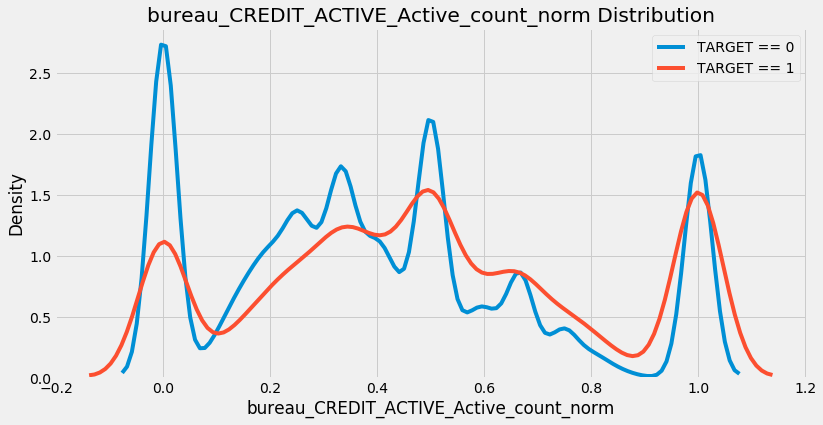

In [91]:
kde_target(var_name='bureau_CREDIT_ACTIVE_Active_count_norm',df=train)

이 변수는 CREAD_ACTIVE 값이 Active인 이전 대출 수를 고객에 대한 이전 대출 총 수로 나눈 값을 나타냅니다. 여기의 상관관계가 너무 약해서 결론을 내려서는 안 될 것 같아요!

#### Collinear Variables
변수와 목표값의 상관 관계뿐만 아니라 각 변수의 상관 관계도 계산할 수 있습니다. 이를 통해 데이터에서 제거해야 할 높은 선형 변수가 있는지 확인할 수 있습니다.

다른 변수와 0.8 이상의 상관 관계를 갖는 변수를 살펴보겠습니다.

In [92]:
threshold = 0.8
above_threshold_vars={}
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col]>threshold])

상관 관계가 높은 각 변수 쌍에 대해 한 변수만 제거하려고 합니다. 다음 코드는 각 쌍 중 하나만 추가하여 제거할 변수 집합을 만듭니다.

In [93]:
cols_to_remove=[]
cols_seen=[]
cols_to_remove_pair=[]

for key,value in above_threshold_vars.items():
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
                
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ',len(cols_to_remove))

Number of columns to remove:  134


교육 데이터 세트와 테스트 데이터 세트 모두에서 이러한 열을 제거할 수 있습니다. 이러한 변수를 제거한 후 성능을 이러한 변수(아까 저장한 원시 csv 파일)를 유지하는 성능과 비교해야 합니다.

In [94]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 199)
Testing Corrs Removed Shape:  (48744, 198)


In [96]:
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index = False)

## Modeling
이러한 새로운 데이터셋의 성능을 실제로 테스트하기 위해 머신러닝에 사용할 것입니다! 여기서는 다른 노트북에서 개발한 기능을 사용하여 기능(상관성이 높은 변수가 제거된 원시 버전)을 비교할 것입니다. 우리는 이런 종류의 실험을 할 수 있습니다. 그리고 제어는 경쟁사에 제출되었을 때 이 기능에서 응용 프로그램 데이터의 성능이 될 것입니다. 이 성능을 이미 기록했으므로 제어와 두 가지 테스트 조건을 나열할 수 있습니다.

모든 데이터 세트에 대해 정확한 하이퍼 파라미터와 함께 아래에 표시된 모형을 사용합니다.

- control: 응용 프로그램 파일의 데이터만 사용할 수 있습니다.
- test one: bureau 및 bure_balance 파일에서 모든 데이터가 기록된 애플리케이션 파일의 데이터입니다.
- test two: bureau에서 모든 데이터가 기록된 애플리케이션 파일의 데이터와 상관 관계가 높은 변수가 제거된 bureau_balance 파일입니다.

In [97]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt

In [104]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """
        교차 검증을 사용해 light gradient boosting modeld을 교육하고 테스트합니다.
        
    
    매개 변수
    --------
        features (pd.DataFrame): 
            사용할 교육 기능의 데이터 프레임입니다. 
            모델 교육을 위한 것입니다. Target 열을 포함해야 합니다.
        test_features (pd.DataFrame): 
            사용할 테스트 기능의 데이터 프레임입니다.
            모형으로 예측하기 위한 것입니다. 
        encoding (str, default = 'ohe'): 
            범주형 변수를 인코딩하는 방법입니다. 원핫 인코딩의 경우 'ohe' 또는 정수 레이블 인코딩의 경우 'le'입니다.
        n_folds (int, default = 5): 교차 검증에 사용할 접힘 수입니다.
        
    리턴값
    --------
        submission (pd.DataFrame): 
            'SK_'가 있는 데이터 프레임입니다.ID_CURR 및 'TARTING' 확률입니다.
            모형이 예측한 것입니다.
        feature_importances (pd.DataFrame): 
            데이터 프레임에 모델의 기능 중요도가 포함됩니다.
        valid_metrics (pd.DataFrame): 
            데이터 프레임에 대한 교육 및 검증 메트릭(ROC AUC)이 포함되어 있습니다.
    """
    
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    labels = features['TARGET']
    
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        cat_indices = 'auto'
    
    elif encoding == 'le':
        
        label_encoder = LabelEncoder()
        
        cat_indices = []
        
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                cat_indices.append(i)
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    feature_names = list(features.columns)
    
    features = np.array(features)
    test_features = np.array(test_features)
    
    k_fold = KFold(n_splits = n_folds,shuffle=True,random_state = 50)
    
    feature_importance_values = np.zeros(len(feature_names))
    
    test_predictions = np.zeros(test_features.shape[0])
    
    out_of_fold = np.zeros(features.shape[0])
    
    valid_scores = []
    train_scores = []
    
    for train_indices, valid_indices in k_fold.split(features):
    
        train_features, train_labels = features[train_indices], labels[train_indices]
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        best_iteration = model.best_iteration_
        
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [99]:
def plot_feature_importances(df):
    """
    모형에 의해 반환되는 중요도 그림입니다. 이 기능은 다음 중 어느 정도에서도 작동합니다.
    더 높은 중요도를 제공하는 기능 중요도입니다. 
    
    매개변수:
       df (dataframe): 기능 중요도입니다. feature,importance라는 열이 있어야 합니다.
        
    리턴값
        가장 중요한 15개 피쳐의 그래프를 보여줍니다.
        
        df (dataframe): 정규화된 importance들을 정렬한 기능 중요도(feature importance)입니다. 
        """
    
    df = df.sort_values('importance', ascending = False).reset_index()
    
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    plt.figure(figsize = (10, 6))
    ax = plt.subplot()

    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

#### Control
모든 실험의 첫 번째 단계는 제어장치를 설정하는 것입니다. 이를 위해 위에서 정의한 기능(그라디언트 부스팅 머신 모델 구현)과 단일 메인 데이터 소스(애플리케이션)를 사용합니다.

In [100]:
train_control = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/home_credit/application_train.csv')
test_control = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/home_credit/application_test.csv')

다행히, 우리가 시간을 들여 함수를 작성한 후에는 간단한 기능을 사용할 수 있습니다(이 노트북에 중심 테마가 있으면 기능을 사용하여 작업을 단순하고 재현할 수 있습니다!). 위의 함수는 경쟁업체에 업로드할 수 있는 제출 데이터 프레임, 기능 중요도의 fi 데이터 프레임, 검증 및 테스트 성능이 포함된 메트릭 데이터 프레임을 반환합니다.

In [105]:
submission, fi, metrics = model(train_control, test_control)

Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.7989	train's binary_logloss: 0.547642	valid's auc: 0.755463	valid's binary_logloss: 0.563361
[400]	train's auc: 0.82864	train's binary_logloss: 0.518235	valid's auc: 0.755594	valid's binary_logloss: 0.544951
Early stopping, best iteration is:
[309]	train's auc: 0.815791	train's binary_logloss: 0.531059	valid's auc: 0.755755	valid's binary_logloss: 0.55289
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798638	train's binary_logloss: 0.547974	valid's auc: 0.758354	valid's binary_logloss: 0.56326
Early stopping, best iteration is:
[282]	train's auc: 0.811912	train's binary_logloss: 0.53493	valid's auc: 0.758533	valid's binary_logloss: 0.555531
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.7977	train's binary_logloss: 0.549358	valid's auc: 0.763287	valid's binary_logl

In [106]:
metrics

,fold,train,valid
0,0,0.815791,0.755755
1,1,0.811912,0.758533
2,2,0.811252,0.763822
3,3,0.805899,0.758345
4,4,0.807459,0.758535
5,overall,0.810463,0.759002


이 컨트롤은 교육 점수가 검증 점수보다 높기 때문에 약간 오버핏됩니다. 정규화를 살펴볼 때 이 문제를 나중에 노트북에서 해결할 수 있습니다(이미 이 모델에서 reg_lambda 및 reg_alpha를 사용하여 일부 정규화를 수행함).

우리는 형상 중요성을 다른 함수인 plot_feature_importance로 시각화할 수 있습니다. 피쳐를 선택할 때 피쳐 중요도가 유용할 수 있습니다.

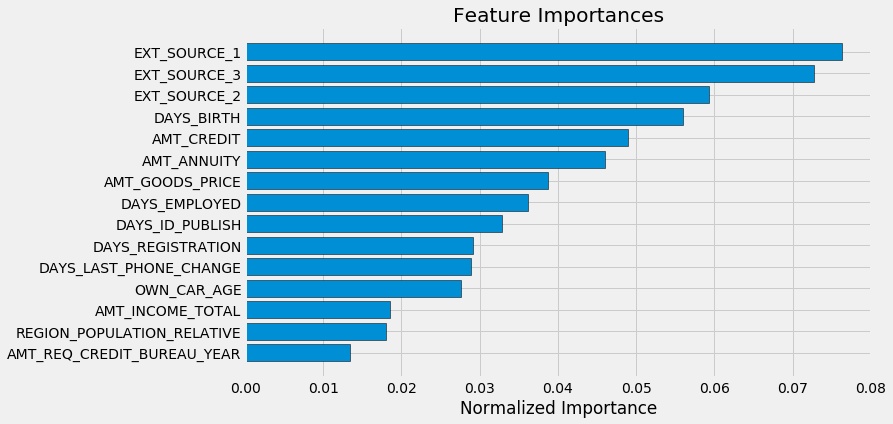

In [108]:
fi_sorted = plot_feature_importances(fi)

In [109]:
submission.to_csv('control.csv', index = False)

이 컨트롤은 경기에 제출될 때 0.745점을 받습니다.

#### Test One
첫 번째 테스트를 해보겠습니다. 대부분의 작업을 수행하는 기능에 데이터를 전달하기만 하면 됩니다.

In [110]:
submission_raw, fi_raw, metrics_raw = model(train, test)

Training Data Shape:  (307511, 452)
Testing Data Shape:  (48744, 452)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.810821	train's binary_logloss: 0.53617	valid's auc: 0.763279	valid's binary_logloss: 0.553134
Early stopping, best iteration is:
[271]	train's auc: 0.82366	train's binary_logloss: 0.523194	valid's auc: 0.76373	valid's binary_logloss: 0.544893
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.810727	train's binary_logloss: 0.53666	valid's auc: 0.765248	valid's binary_logloss: 0.553447
Early stopping, best iteration is:
[276]	train's auc: 0.824682	train's binary_logloss: 0.522383	valid's auc: 0.76609	valid's binary_logloss: 0.544495
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.809569	train's binary_logloss: 0.538079	valid's auc: 0.770517	valid's binary_logloss: 0.55476
Early stopping, best iteration is:
[294]	train's auc: 0.826798	train's binary_logloss: 0.520697	vali

In [111]:
metrics_raw

,fold,train,valid
0,0,0.823660,0.763730
1,1,0.824682,0.766090
2,2,0.826798,0.771361
3,3,0.817720,0.766206
4,4,0.821525,0.764642
5,overall,0.822877,0.766403


이러한 숫자에 기초하여 설계된 기능은 제어 케이스보다 성능이 우수합니다. 그러나, 우리는 이 더 나은 검증 성능이 테스트 데이터로 이전되는지 여부를 말하기 전에 미리 예측 사항을 리더보드에 제출해야 합니다.

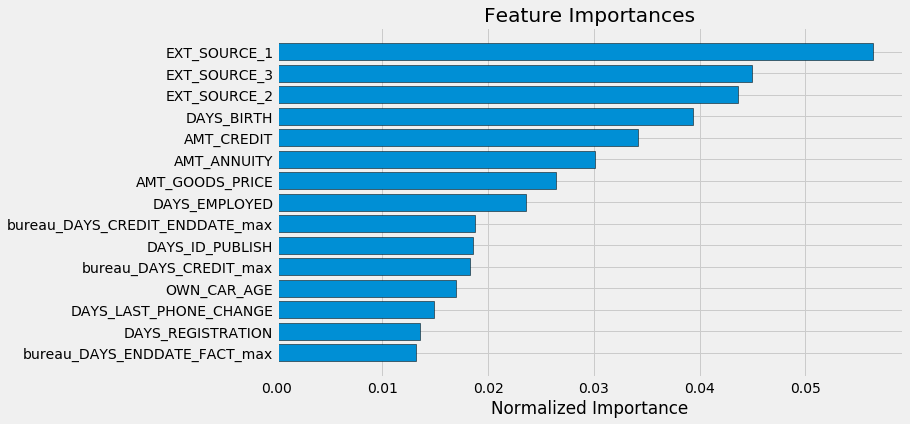

In [112]:
fi_raw_sorted = plot_feature_importances(fi_raw)

기능 개선을 살펴보면, 우리가 구성한 기능 중 몇 가지가 가장 중요한 기능인 것 같습니다. 이 노트북에서 가장 중요한 100대 기능 중 차지하는 비율을 알아보겠습니다. 하지만, 우리는 원래 특징과 비교만 할 것이 아니라, 하나의 핫 인코딩된 원래 특징과 비교해야 합니다. 이것들은 이미 원본 데이터로부터 fi로 기록되어 있습니다.

In [113]:
top_100 = list(fi_raw_sorted['feature'])[:100]
new_features = [x for x in top_100 if x not in list(fi['feature'])]

print('%% of Top 100 Features created from the bureau data = %d.00' % len(new_features))

% of Top 100 Features created from the bureau data = 52.00


100개의 특성 중 절반 이상이 우리가 가공한 데이터 입니다. 그렇게 되면 우리가 한 모든 노력이 보람찼다는 자신감을 얻을 수 있을 거예요.

In [114]:
submission_raw.to_csv('test_one.csv', index = False)

제출결과, 테스트 1은 0.759점입니다.

#### Test Two
쉬웠으니까 한 번 더 해보죠! 이전과 동일하지만 높은 공선 변수가 제거되었습니다.

In [116]:
submission_corrs, fi_corrs, metrics_corr = model(train_corrs_removed, test_corrs_removed)

Training Data Shape:  (307511, 318)
Testing Data Shape:  (48744, 318)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.807062	train's binary_logloss: 0.539926	valid's auc: 0.761756	valid's binary_logloss: 0.555974
Early stopping, best iteration is:
[274]	train's auc: 0.81989	train's binary_logloss: 0.526962	valid's auc: 0.762222	valid's binary_logloss: 0.547766
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.807403	train's binary_logloss: 0.539835	valid's auc: 0.762487	valid's binary_logloss: 0.556178
Early stopping, best iteration is:
[249]	train's auc: 0.816296	train's binary_logloss: 0.53081	valid's auc: 0.762811	valid's binary_logloss: 0.5508
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.806206	train's binary_logloss: 0.541195	valid's auc: 0.766958	valid's binary_logloss: 0.557491
[400]	train's auc: 0.83864	train's binary_logloss: 0.508571	valid's auc: 0.767385	valid's binary_l

In [117]:
metrics_corr

,fold,train,valid
0,0,0.819890,0.762222
1,1,0.816296,0.762811
2,2,0.835801,0.767546
3,3,0.807812,0.763488
4,4,0.823635,0.761030
5,overall,0.820687,0.763372


이러한 결과는 컨트롤보다는 낫지만 raw보다는 약간 낮습니다.

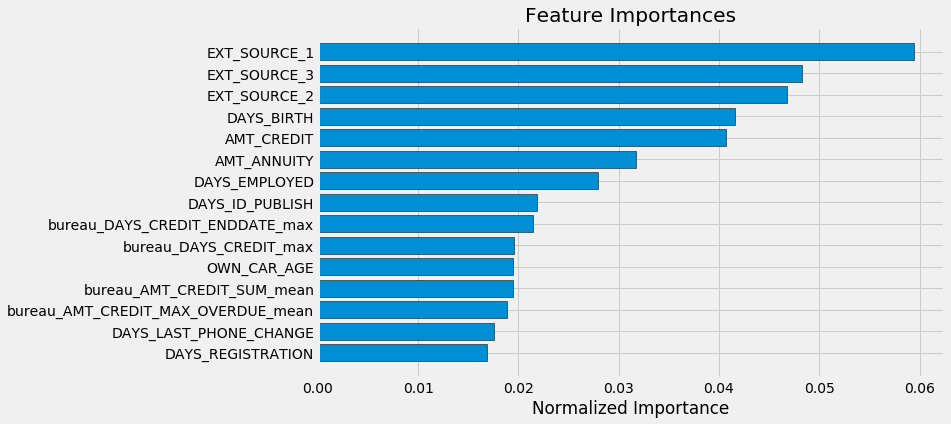

In [119]:
fi_corrs_sorted = plot_feature_importances(fi_corrs)

In [120]:
submission_corrs.to_csv('test_two.csv', index = False)

테스트 2는 경기에 제출될 때 0.753점을 받습니다.

## Results
그 모든 작업을 마친 후, 추가 정보를 포함하면 성능이 향상되었다고 말할 수 있습니다! 모델은 데이터에 최적화되어 있지 않지만 계산된 기능을 사용할 때 원래 데이터 세트에 비해 눈에 띄게 향상되었습니다. 이제 공식적으로 다음 성과를 요약해 보겠습니다.

실험 열차 AUC 유효성 검사 AUC 테스트 AUC입니다.
컨트롤 0.8150.7600.745입니다.
검정 1 0.8370.767 0.759입니다.
검정 2 0.826 0.765 0.753입니다.
이러한 점수는 노트북의 실행에서 실행으로 변경될 수 있습니다. 그러나 일반적인 주문은 변경되지 않았습니다.)

우리의 모든 노력은 원본 테스트 데이터에 비해 0.014 ROC AUC의 소폭 개선으로 이어집니다. 높은 선형 변수를 제거하면 성능이 약간 저하되므로 형상 선택을 위한 다른 방법을 고려하고자 합니다. 또한, 우리가 구축한 기능 중 일부는 모델에 의해 판단되는 가장 중요한 기능 중 하나라고 말할 수 있습니다.

이와 같은 경쟁에서는 이러한 규모의 개선만으로도 우리는 리더보드에서 100대 이상의 위치를 차지하기에 충분합니다. 이 노트북과 같은 여러 가지 작은 개선 작업을 통해 점차적으로 더 나은 성능을 달성할 수 있습니다. 저는 다른 사람들이 결과를 사용하여 자신의 개선 사항을 만들 것을 권장하며, 제가 다른 사람들을 돕기 위해 취하는 조치들을 계속 문서화할 것입니다.

다음 단계입니다.
이제 이 노트북에서 개발한 기능을 다른 데이터 세트에 사용할 수 있습니다. 우리 모델에는 아직 4개의 다른 데이터 파일이 있습니다! 다음 노트북에서는 이러한 기타 데이터 파일(홈 크레딧의 이전 대출에 대한 정보가 들어 있음)의 정보를 교육 데이터에 통합합니다. 그런 다음 동일한 모델을 구축하고 더 많은 실험을 수행하여 기능 엔지니어링의 효과를 확인할 수 있습니다. 이 대회에서는 더 많은 작업을 수행해야 하고, 더 많은 성과를 얻을 수 있어야 합니다! 다음 공책에서 뵙겠습니다.